In [86]:
import json
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from dateutil.relativedelta import relativedelta

In [87]:
data = pd.read_csv('returns.csv', index_col = 0)
data.index = pd.to_datetime(data.index)
data = data[1:]
data.head()

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.076389,-0.084310,NaN,NaN,-0.028572,-0.005435,NaN,-0.083889,-0.050589,-0.010416,...,NaN,-0.037568,NaN,0.023026,-0.019153,NaN,-0.020101,NaN,-0.014428,NaN
2000-01-05,-0.062030,0.014633,NaN,NaN,-0.001838,0.092896,NaN,0.019771,0.014598,-0.015790,...,NaN,0.052975,NaN,0.038585,0.054515,NaN,0.005129,NaN,0.019144,NaN
2000-01-06,-0.038077,-0.086539,NaN,NaN,0.034991,-0.010000,NaN,0.008163,-0.027337,0.005347,...,NaN,0.046778,NaN,-0.009288,0.051697,NaN,-0.008503,NaN,-0.054144,NaN
2000-01-07,0.083334,0.047369,NaN,NaN,0.010676,0.055556,NaN,0.048583,0.028106,0.015958,...,NaN,-0.032883,NaN,0.000000,-0.002934,NaN,-0.022299,NaN,-0.011098,NaN
2000-01-10,0.060577,-0.017588,NaN,NaN,-0.007042,0.033493,NaN,0.038610,0.087051,0.000000,...,NaN,-0.004359,NaN,0.000000,-0.013981,NaN,0.040350,NaN,0.033668,NaN


In [88]:
# data.isnull().values.any()
# cols_with_nan = data.columns[data.isna().any()]
# len(cols_with_nan)

In [89]:
# data = data.dropna(axis=1, how="any")
# data

## TODO: are returns in excess returns?

In [90]:
start = data.index[0]
start
end = start + relativedelta(months = 36)
start, end

(Timestamp('2000-01-04 00:00:00'), Timestamp('2003-01-04 00:00:00'))

In [91]:
monthly_dates = data.resample("MS").last().index
monthly_dates

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=288, freq='MS')

In [92]:
from pandas.tseries.offsets import MonthEnd, YearEnd
winnerLosers = pd.DataFrame()

for month in monthly_dates[37:]:
    end = month
    beg = month - relativedelta(months = 37)
    returns36month = data[(data.index >= beg) & (data.index < end)]
    returns36month = returns36month + 1
    cum36 = returns36month.prod() - 1

    winnerLosers[month] = cum36

winnerLosers = winnerLosers.T


/var/folders/rd/6pjhbndj3_xbc_vx64hj0zh00000gn/T/ipykernel_47179/1309513444.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  winnerLosers[month] = cum36


In [93]:
winnerLosers

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2003-02-01,-0.771111,-0.743428,0.000000,0.000000,0.158968,1.653912,0.090969,-0.190522,-0.469328,0.163731,...,0.569277,-0.241318,0.056879,-0.298033,-0.066679,0.000000,0.242479,0.377688,-0.008036,0.000000
2003-03-01,-0.800567,-0.710650,0.000000,0.000000,0.158332,1.137436,0.011206,0.003239,-0.376256,0.080429,...,0.509036,-0.048005,0.093005,-0.302749,-0.115458,0.000000,0.663581,0.491600,0.065766,0.000000
2003-04-01,-0.873405,-0.753283,0.000000,0.000000,0.206830,1.225574,0.021753,-0.392604,-0.650238,0.244836,...,0.676118,0.021339,0.183705,-0.117221,-0.005602,0.000000,0.827605,0.634073,-0.032488,0.000000
2003-05-01,-0.845962,-0.790593,0.000000,0.000000,0.230202,1.122138,0.056031,-0.376775,-0.588571,0.246149,...,0.887296,-0.039055,0.306687,-0.176699,-0.032996,0.000000,0.590342,0.575941,0.333400,0.000000
2003-06-01,-0.795430,-0.710630,0.000000,0.000000,0.228674,1.404062,0.154911,-0.413252,-0.498128,0.404787,...,0.913315,0.042556,0.447348,-0.160964,0.011145,0.000000,0.650775,0.507393,0.280175,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.404287,1.193984,0.753127,0.051690,0.284532,1.711693,0.541165,0.254669,0.717720,1.282472,...,0.118478,0.732905,0.466339,0.092011,1.809223,0.797338,0.672404,0.218315,0.203204,0.403253
2023-09-01,0.280841,0.803225,0.760279,-0.090941,0.074443,1.499512,0.501220,0.258868,0.671057,0.995244,...,0.026240,0.353475,0.406586,-0.099683,2.120806,0.473896,0.507262,-0.070244,-0.020445,0.282328
2023-10-01,0.134801,0.350781,0.769400,-0.051828,-0.070299,1.527267,0.334059,-0.006798,0.580945,0.801071,...,0.063991,0.162589,0.061920,-0.095758,2.409713,0.175665,0.375916,-0.159708,-0.174502,0.109475
2023-11-01,0.045746,0.501224,0.850711,-0.182572,-0.081987,1.963419,0.375820,0.084885,0.422288,0.645530,...,0.178304,0.156168,0.228410,-0.063006,2.571161,0.151498,0.397315,-0.192392,-0.170443,-0.028392


In [94]:

np.floor(len(winnerLosers.iloc[0]) * 0.10)

50.0

In [95]:
import math

def top10_long_short_equal_weight(row):
    mask = (row.notna()) & (row != 0)
    ten_percent = math.floor(len(mask) * 0.10)
    top = row.nlargest(ten_percent).index
    bot = row.nsmallest(ten_percent).index
    weight = pd.Series(0, index = row.index)
    weight[top] = -1 / ten_percent
    weight[bot] = 1 / ten_percent
    return weight

In [96]:
weights = winnerLosers.apply(top10_long_short_equal_weight, axis = 1)
weights

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
2003-02-01,0.02,0.02,0.0,0.0,0.0,-0.02,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
2003-03-01,0.02,0.02,0.0,0.0,0.0,-0.02,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
2003-04-01,0.02,0.02,0.0,0.0,0.0,-0.02,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
2003-05-01,0.02,0.02,0.0,0.0,0.0,-0.02,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
2003-06-01,0.02,0.02,0.0,0.0,0.0,-0.02,0.0,0.0,0.02,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.00,0.00,0.0,0.0,0.0,-0.02,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,-0.02,0.0,0.0,0.0,0.00,0.0
2023-09-01,0.00,0.00,0.0,0.0,0.0,-0.02,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.02,-0.02,0.0,0.0,0.0,0.00,0.0
2023-10-01,0.00,0.00,0.0,0.0,0.0,-0.02,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,-0.02,0.0,0.0,0.0,0.00,0.0
2023-11-01,0.00,0.00,0.0,0.0,0.0,-0.02,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,-0.02,0.0,0.0,0.0,0.00,0.0


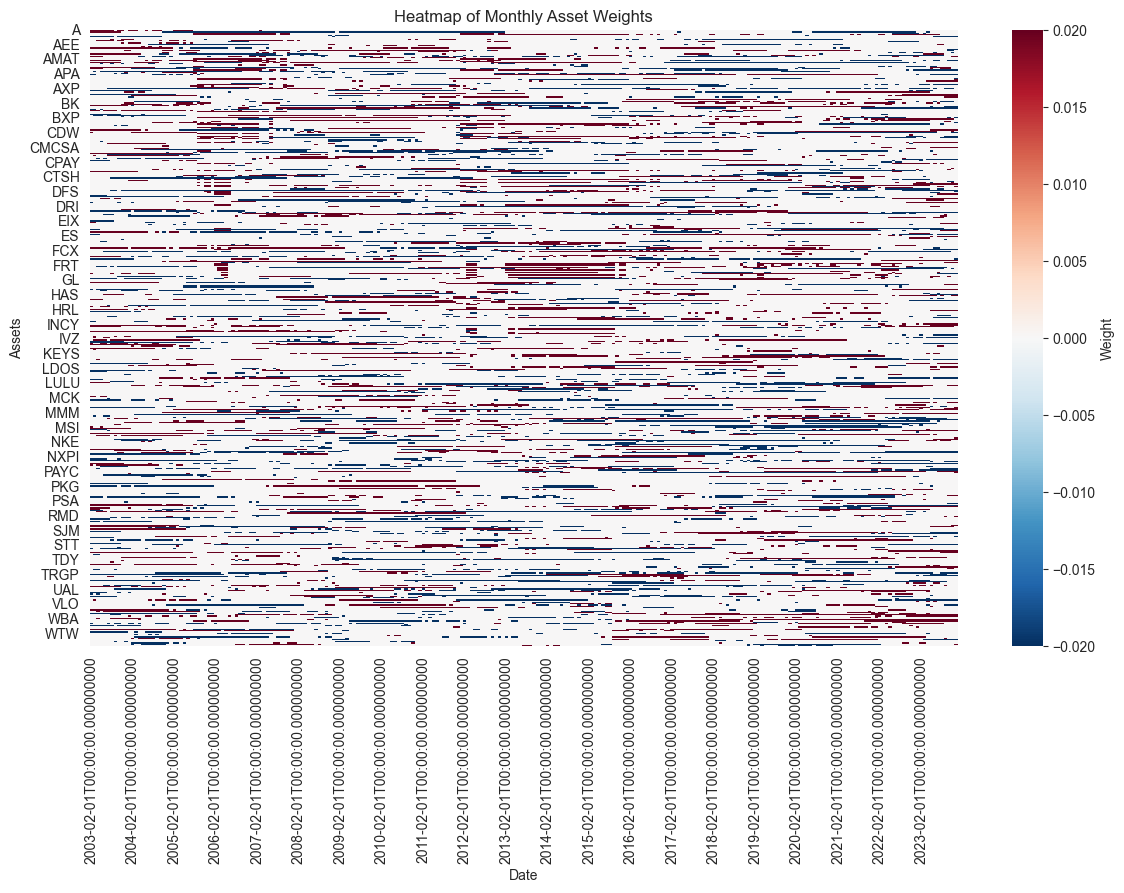

In [97]:

assets = weights.iloc[0].index

plt.figure(figsize=(14,8))
sns.heatmap(weights[assets].T,
    cmap='RdBu_r',
    cbar_kws={'label':'Weight'},
    xticklabels=12,
    # yticklabels=False
)
plt.xlabel('Date')
plt.ylabel('Assets')
plt.title('Heatmap of Monthly Asset Weights')
plt.show()



In [98]:
portfolio = pd.DataFrame()

for month in weights.index:
    beg = month
    end = beg + MonthEnd(0)
    ret_month = data.loc[beg:end] # filter the monthly returns for this period
    cum_month = (1 + ret_month).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_month= cum_month.shift(1)
    cum_month.iloc[0] = 1

    ini_weight = weights.loc[month] # get initial weights for the period
    month_weights = cum_month.multiply(ini_weight, axis=1)
    
    ret_portfolio = (month_weights * ret_month).sum(axis = 1)
    portfolio = pd.concat([portfolio, ret_portfolio])
    
portfolio.columns = ["Portfolio Return"]
portfolio

,Portfolio Return
2003-02-03,-0.004137
2003-02-04,-0.010576
2003-02-05,0.002561
2003-02-06,-0.005837
2003-02-07,0.001972
...,...
2023-12-22,0.001650
2023-12-26,-0.000413
2023-12-27,0.004161
2023-12-28,0.012315


In [99]:
yearly_dates = data.resample("AS").last().index
yearly_dates


DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'],
              dtype='datetime64[ns]', name='Date', freq='AS-JAN')

In [100]:
portfolioanual = pd.DataFrame()

for year in weights.index:
    beg = year
    end = beg + YearEnd(0)
    ret_year = data.loc[beg:end] # filter the monthly returns for this period
    cum_year = (1 + ret_year).cumprod() # compute cum returns (no daily rebalancing)

    # adjust for equal weights in first trading day of month
    cum_year = cum_year.shift(1)
    cum_year.iloc[0] = 1

    ini_weight = weights.loc[year] # get initial weights for the period
    year_weights = cum_year.multiply(ini_weight, axis=1)

    ret_portfolioanual = (year_weights * ret_year).sum(axis = 1)
    portfolioanual = pd.concat([portfolioanual, ret_portfolioanual])

portfolioanual.columns = ["Portfolio Return Yearly"]
portfolioanual

,Portfolio Return Yearly
2003-02-03,-0.004137
2003-02-04,-0.010576
2003-02-05,0.002561
2003-02-06,-0.005837
2003-02-07,0.001972
...,...
2023-12-22,0.001650
2023-12-26,-0.000413
2023-12-27,0.004161
2023-12-28,0.012315


<Axes: >

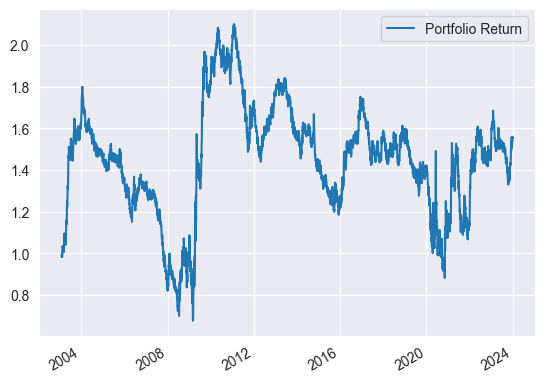

In [101]:
cum_returns = (1 + portfolio).cumprod()
cum_returns.plot()

In [102]:
mupor = portfolio.mean() * 252
sdpor = portfolio.std() * np.sqrt(252)
srpor = mupor / sdpor

print(f"Mu: {mupor[0]}")
print(f"Std: {sdpor[0]}")
print(f"Sharpe: {srpor[0]}")

Mu: 0.04371535991609919
Std: 0.21354224007076697
Sharpe: 0.2047152820988115
